# Cross-validation lung data
Does five-fold crossvalidation in annotating lung data to get stability of different algorithms

In [1]:
import os, sys

import popv
import anndata
import numpy as np
import scanpy as sc
from scanpy.plotting import palettes
import sys
sys.path.insert(-1, '..')
import _utils

2023-02-16 21:17:49.702771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 21:17:49.885938: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-16 21:17:50.474681: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-02-16 21:17:50.474730: W tensorflow/compiler/xla/stream_executor/platf

## Run PopV

In [2]:
refdata_url = '"https://zenodo.org/record/7587774/files/TS_Bladder_filtered.h5ad?download"'
bladder_fn = 'data/Bladder.h5ad'
if not os.path.exists(bladder_fn):
    !wget -O $bladder_fn $refdata_url

bladder = anndata.read(bladder_fn)

In [3]:
bladder

AnnData object with n_obs × n_vars = 24583 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay'
    var: 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'

In [4]:
query_index = np.random.choice([0,1,2,3,4], size = len(bladder), replace=True)

In [17]:
if not os.path.exists('data'):
    os.mkdir('data')

In [18]:
for i in range(0,5):
    ref_adata_path = "data/ref_{}.h5ad".format(i)
    query_adata_path = "data/query_{}.h5ad".format(i)
    bladder[query_index!=i].write(ref_adata_path)
    bladder[query_index==i].write(query_adata_path)

In [19]:
save_folder = 'popv_results'
query_batch_key = 'donor_assay'

# Lesser used parameters
query_labels_key=None
unknown_celltype_label='unknown'

# Following parameters are specific to Tabula Sapiens dataset
ref_labels_key='cell_ontology_class'
ref_batch_key = 'donor_assay'

In [20]:
from popv.preprocessing import Process_Query
from popv.annotation import annotate_data

In [ ]:
for i in range(0,5):
    print(i)
    save_folder = f'cv_run_{i}/popv_results_{i}'
    if not os.path.exists(f'cv_run_{i}'):
        os.mkdir(f'cv_run_{i}')
    
    ref_adata_path = "data/ref_{}.h5ad".format(i)
    query_adata_path = "data/query_{}.h5ad".format(i)
    
    # read in the reference dataset
    ref_adata = anndata.read(ref_adata_path)
    query_adata = anndata.read(query_adata_path)
    
    min_celltype_size = np.min(ref_adata.obs.groupby('cell_ontology_class').size())
    n_samples_per_label = np.max((min_celltype_size, 100))
    
    adata = Process_Query(
        query_adata,
        ref_adata,
        query_labels_key=query_labels_key,
        query_batch_key=query_batch_key,
        ref_labels_key=ref_labels_key,
        ref_batch_key=ref_batch_key,
        unknown_celltype_label=unknown_celltype_label,
        save_path_trained_models=f'cv_run_{i}/pretrained_models/',
        cl_obo_folder='../PopV/ontology/',
        prediction_mode='retrain',
        n_samples_per_label=n_samples_per_label,
        use_gpu=True,
        compute_embedding=True,
        hvg=4000
    ).adata
    
    annotate_data(adata, save_path=save_folder)
    adata.write(f'cv_run_{i}/annotated_query.h5ad')

## Evaluate results

In [31]:
bladder = sc.read('data/Bladder.h5ad')

In [32]:
i = 0
query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
pred_keys = query.uns['prediction_keys']
query = popv.annotation.ontology_vote_onclass(query, prediction_keys=pred_keys, save_key="popv_prediction")

In [42]:
query.obsm['X_umap'] = query.obsm['X_scvi_umap_popv']

In [39]:
bladder.obs['cv_prediction'] = 'na'

for k in pred_keys:
    bladder.obs[k] = 'na'
for k in ['popv_prediction_depth', 'popv_prediction_onclass_relative_depth']:
    bladder.obs[k] = 'na'

bladder.obs['cv_idx'] = 'na'

In [40]:
names = []
for i in range(5):
    print(i)
    query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
    query = popv.annotation.ontology_vote_onclass(query, prediction_keys=pred_keys, save_key="popv_prediction")
    names.append(query.obs_names)
    bladder.obs.loc[query.obs_names, 'cv_prediction'] = query.obs['popv_prediction'].astype('str')
    bladder.obs.loc[query.obs_names, 'cv_prediction_score'] = query.obs['popv_prediction_score'].astype('str')
    bladder.obs.loc[query.obs_names, 'cv_idx'] = str(i)
    for k in pred_keys:
        bladder.obs.loc[query.obs_names, k] = query.obs[k].astype('str')
    for k in ['popv_prediction_depth', 'popv_prediction_onclass_relative_depth']:
        bladder.obs.loc[query.obs_names, k] = query.obs[k].astype('str')

0


/tmp/ipykernel_229223/847114973.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  bladder.obs.loc[query.obs_names, 'cv_prediction_score'] = query.obs['popv_prediction_score'].astype('str')


1
2
3
4


... storing 'popv_onclass_prediction_sub' as categorical


maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 43 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'K', 'N', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'x', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 37, 38, 39, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92]
Closed glyph list over 'GSUB': 48 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'K', 'N', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'fi', 'five', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'thre

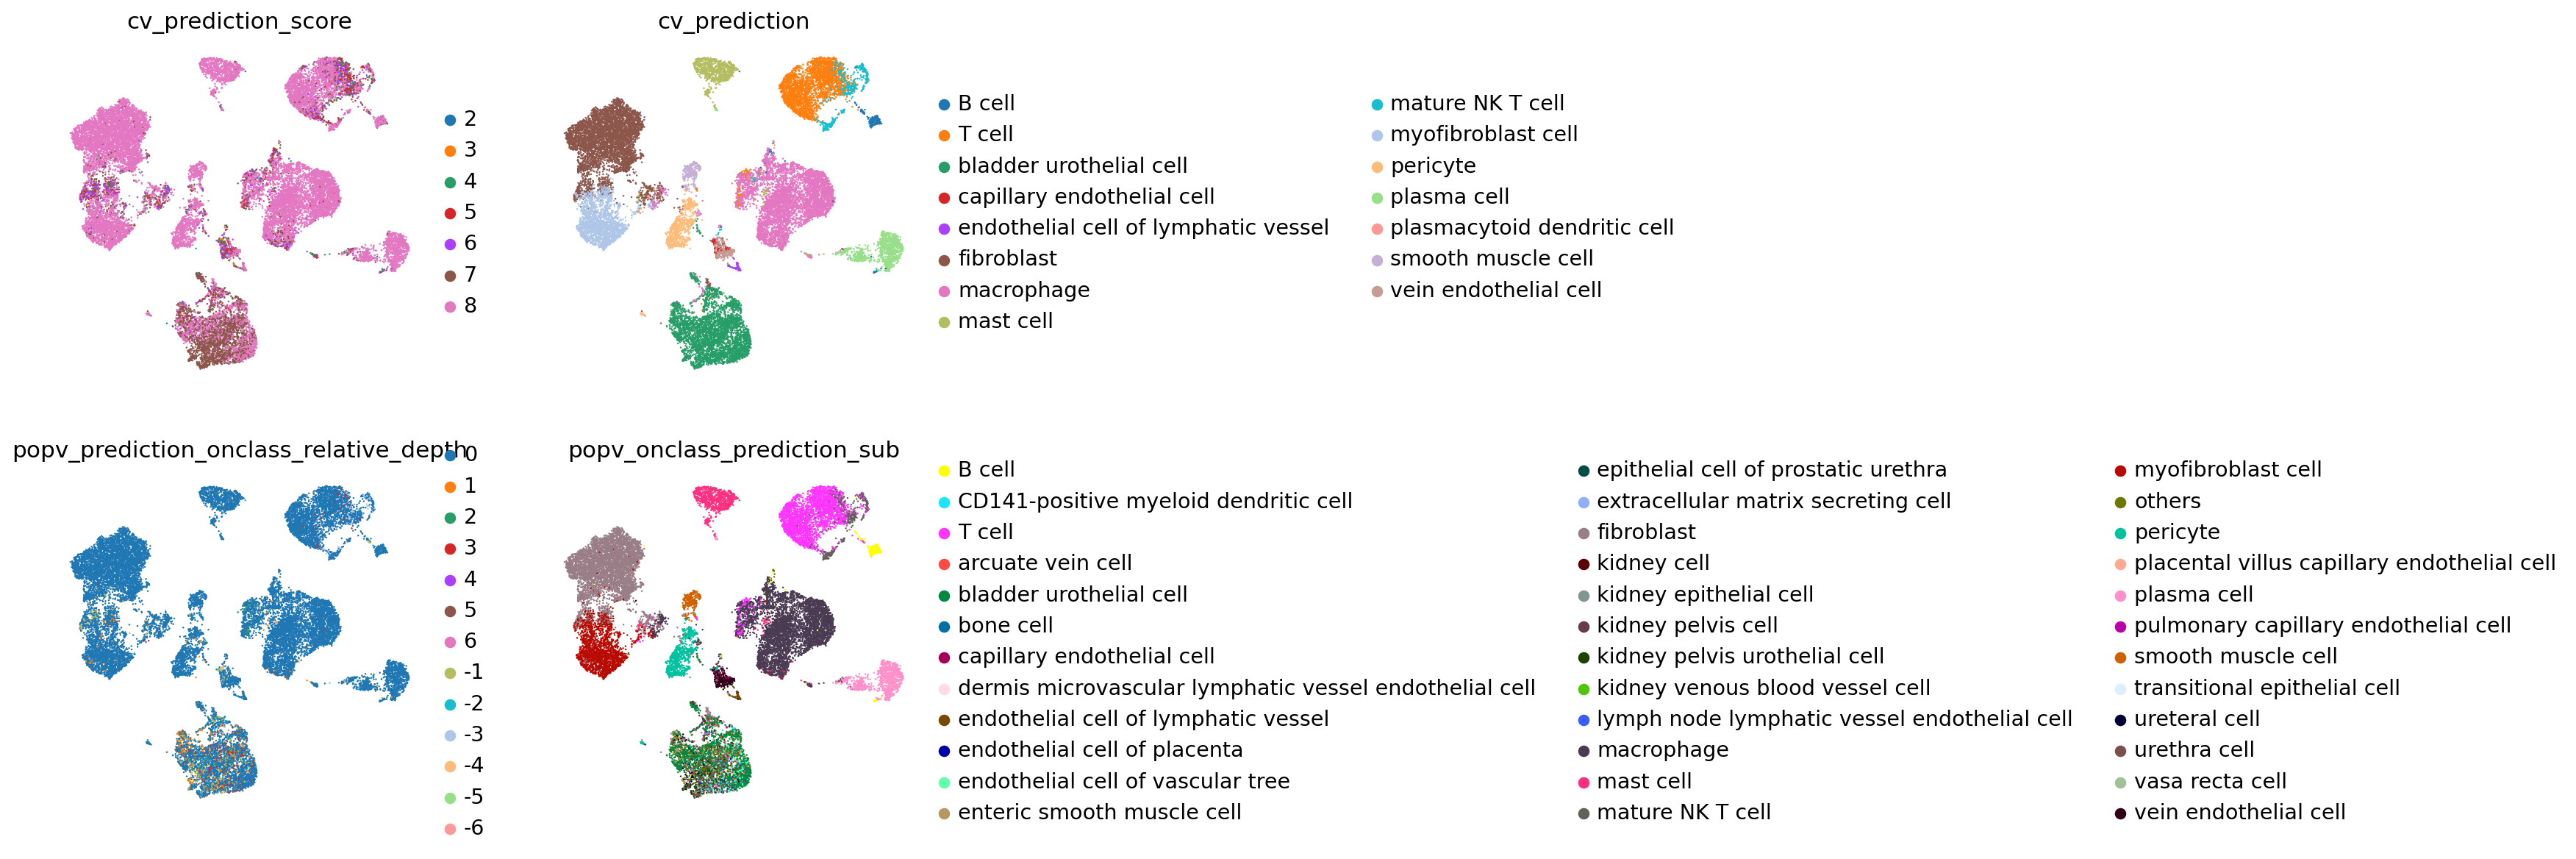

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 41 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'x', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 37, 38, 39, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92]
Closed glyph list over 'GSUB': 46 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'fi', 'five', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore'

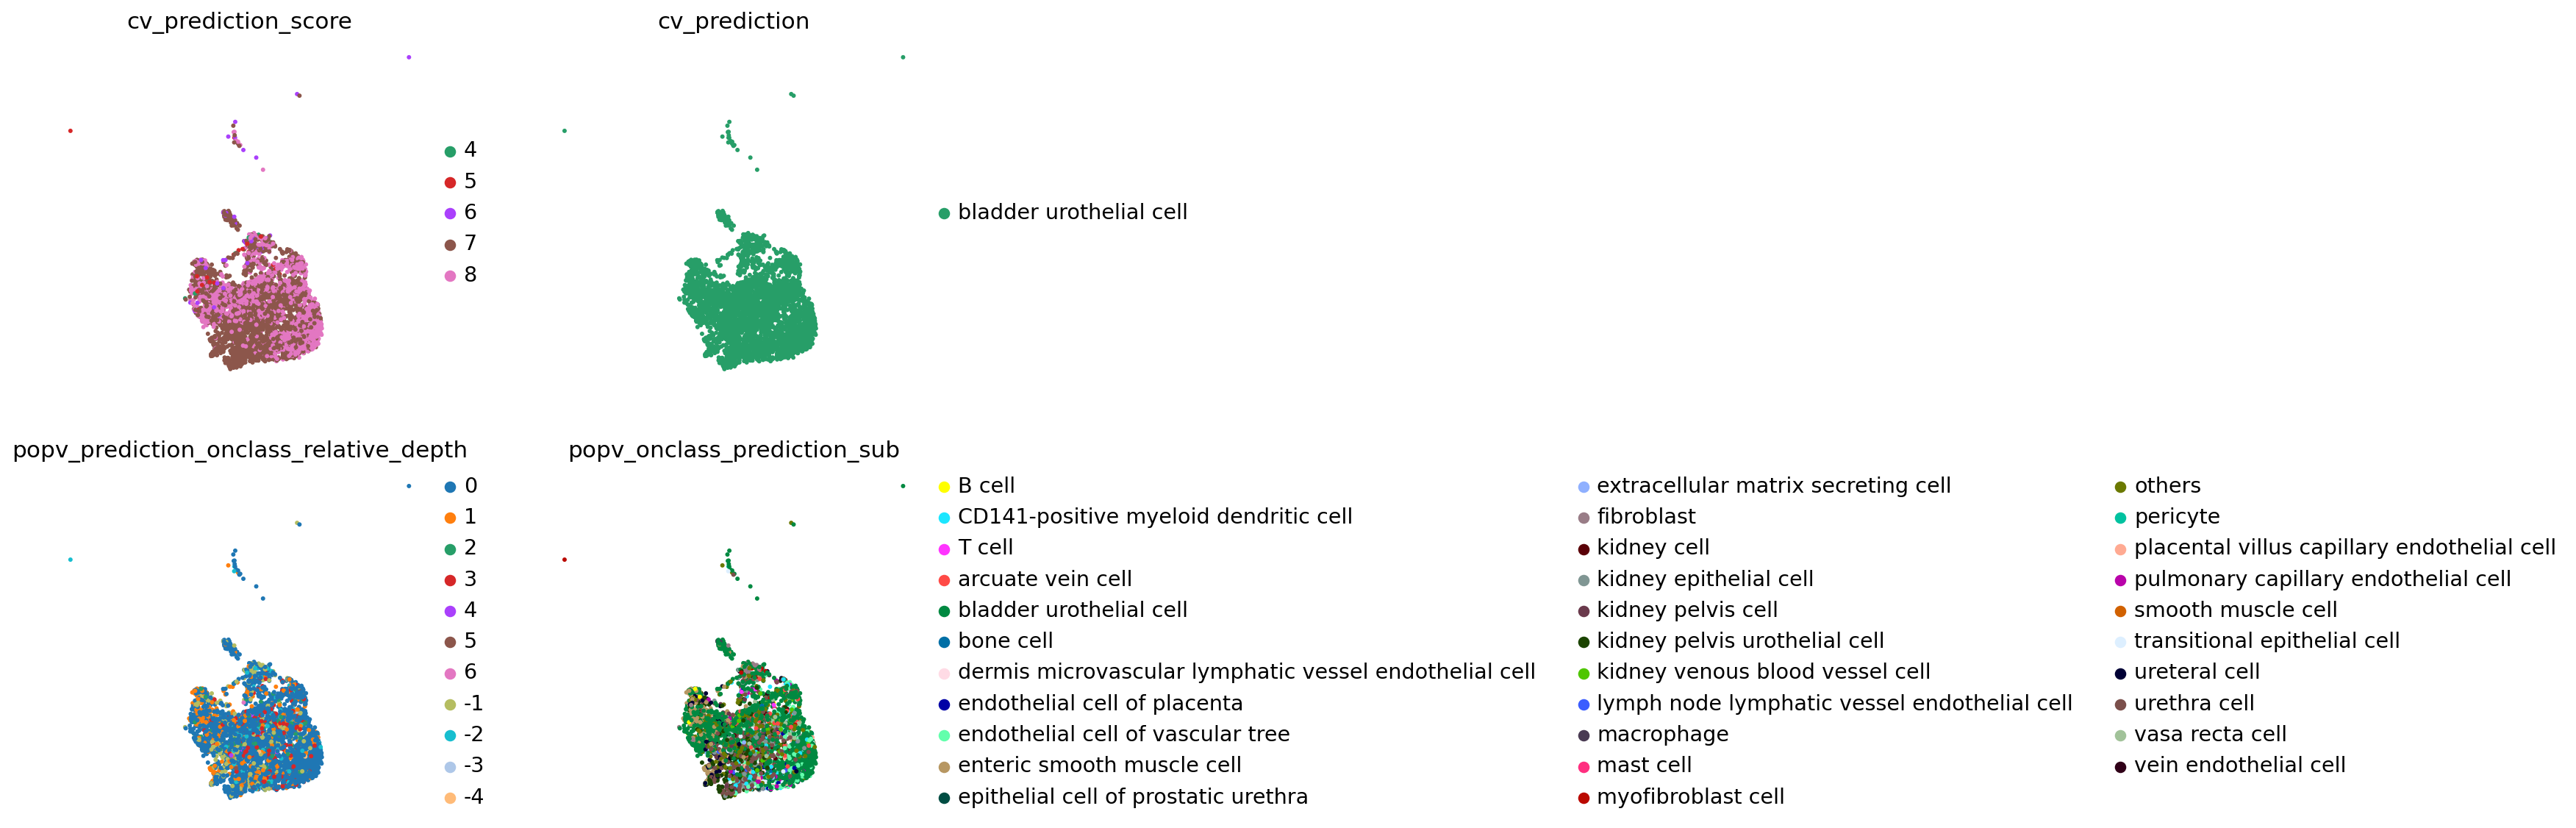

In [58]:
query.obs[['cv_prediction_score', 'cv_prediction', 'popv_prediction_onclass_relative_depth', 'popv_onclass_prediction_sub']] = bladder.obs[
    ['cv_prediction_score', 'cv_prediction', 'popv_prediction_onclass_relative_depth', 'popv_onclass_prediction_sub']]
query.obs['popv_onclass_prediction_sub'] = query.obs['popv_onclass_prediction'].astype(str)
query.obs.loc[query.obs_names[query.obs["popv_onclass_prediction"].isin(
                    query.obs["popv_onclass_prediction"].value_counts()[
                        query.obs[
                            "popv_onclass_prediction"].value_counts() < 20].keys()
                    )], 'popv_onclass_prediction_sub'] = 'others'
sc.pl.umap(
    query,
    color=['cv_prediction_score', 'cv_prediction', 'popv_prediction_onclass_relative_depth', 'popv_onclass_prediction_sub'],
    ncols=2, save='onclass_all_cells.pdf', frameon=False)

urothelial = query[query.obs['cv_prediction']=='bladder urothelial cell']

sc.pl.umap(
    urothelial,
    color=['cv_prediction_score', 'cv_prediction', 'popv_prediction_onclass_relative_depth', 'popv_onclass_prediction_sub'],
    ncols=2, save='onclass_epithelial_cells.pdf', frameon=False)

In [59]:
sc.pp.neighbors(urothelial, use_rep='X_scanvi')
sc.tl.umap(urothelial)

urothelial.obs.loc[urothelial.obs_names[urothelial.obs["popv_onclass_prediction"].isin(
                    urothelial.obs["popv_onclass_prediction"].value_counts()[
                        urothelial.obs[
                            "popv_onclass_prediction"].value_counts() < 20].keys()
                    )], 'popv_onclass_prediction_sub'] = 'others'

In [60]:
urothelial.obs['popv_onclass_prediction_sub'].cat.remove_unused_categories(inplace=True)
urothelial.obs['popv_onclass_prediction_sub'].value_counts()

bladder urothelial cell                                   1653
urethra cell                                               549
kidney pelvis urothelial cell                              394
others                                                     346
endothelial cell of vascular tree                          203
enteric smooth muscle cell                                 168
kidney epithelial cell                                     125
CD141-positive myeloid dendritic cell                      110
ureteral cell                                               80
transitional epithelial cell                                79
pulmonary capillary endothelial cell                        70
fibroblast                                                  40
arcuate vein cell                                           40
kidney pelvis cell                                          38
bone cell                                                   38
endothelial cell of placenta                           

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 39 glyphs before
Glyph names: ['.notdef', '.null', 'C', 'D', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'x', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 38, 39, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92]
Closed glyph list over 'GSUB': 44 glyphs after
Glyph names: ['.notdef', '.null', 'C', 'D', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'fi', 'five', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'uniFB00', 'uniFB03', 'uni

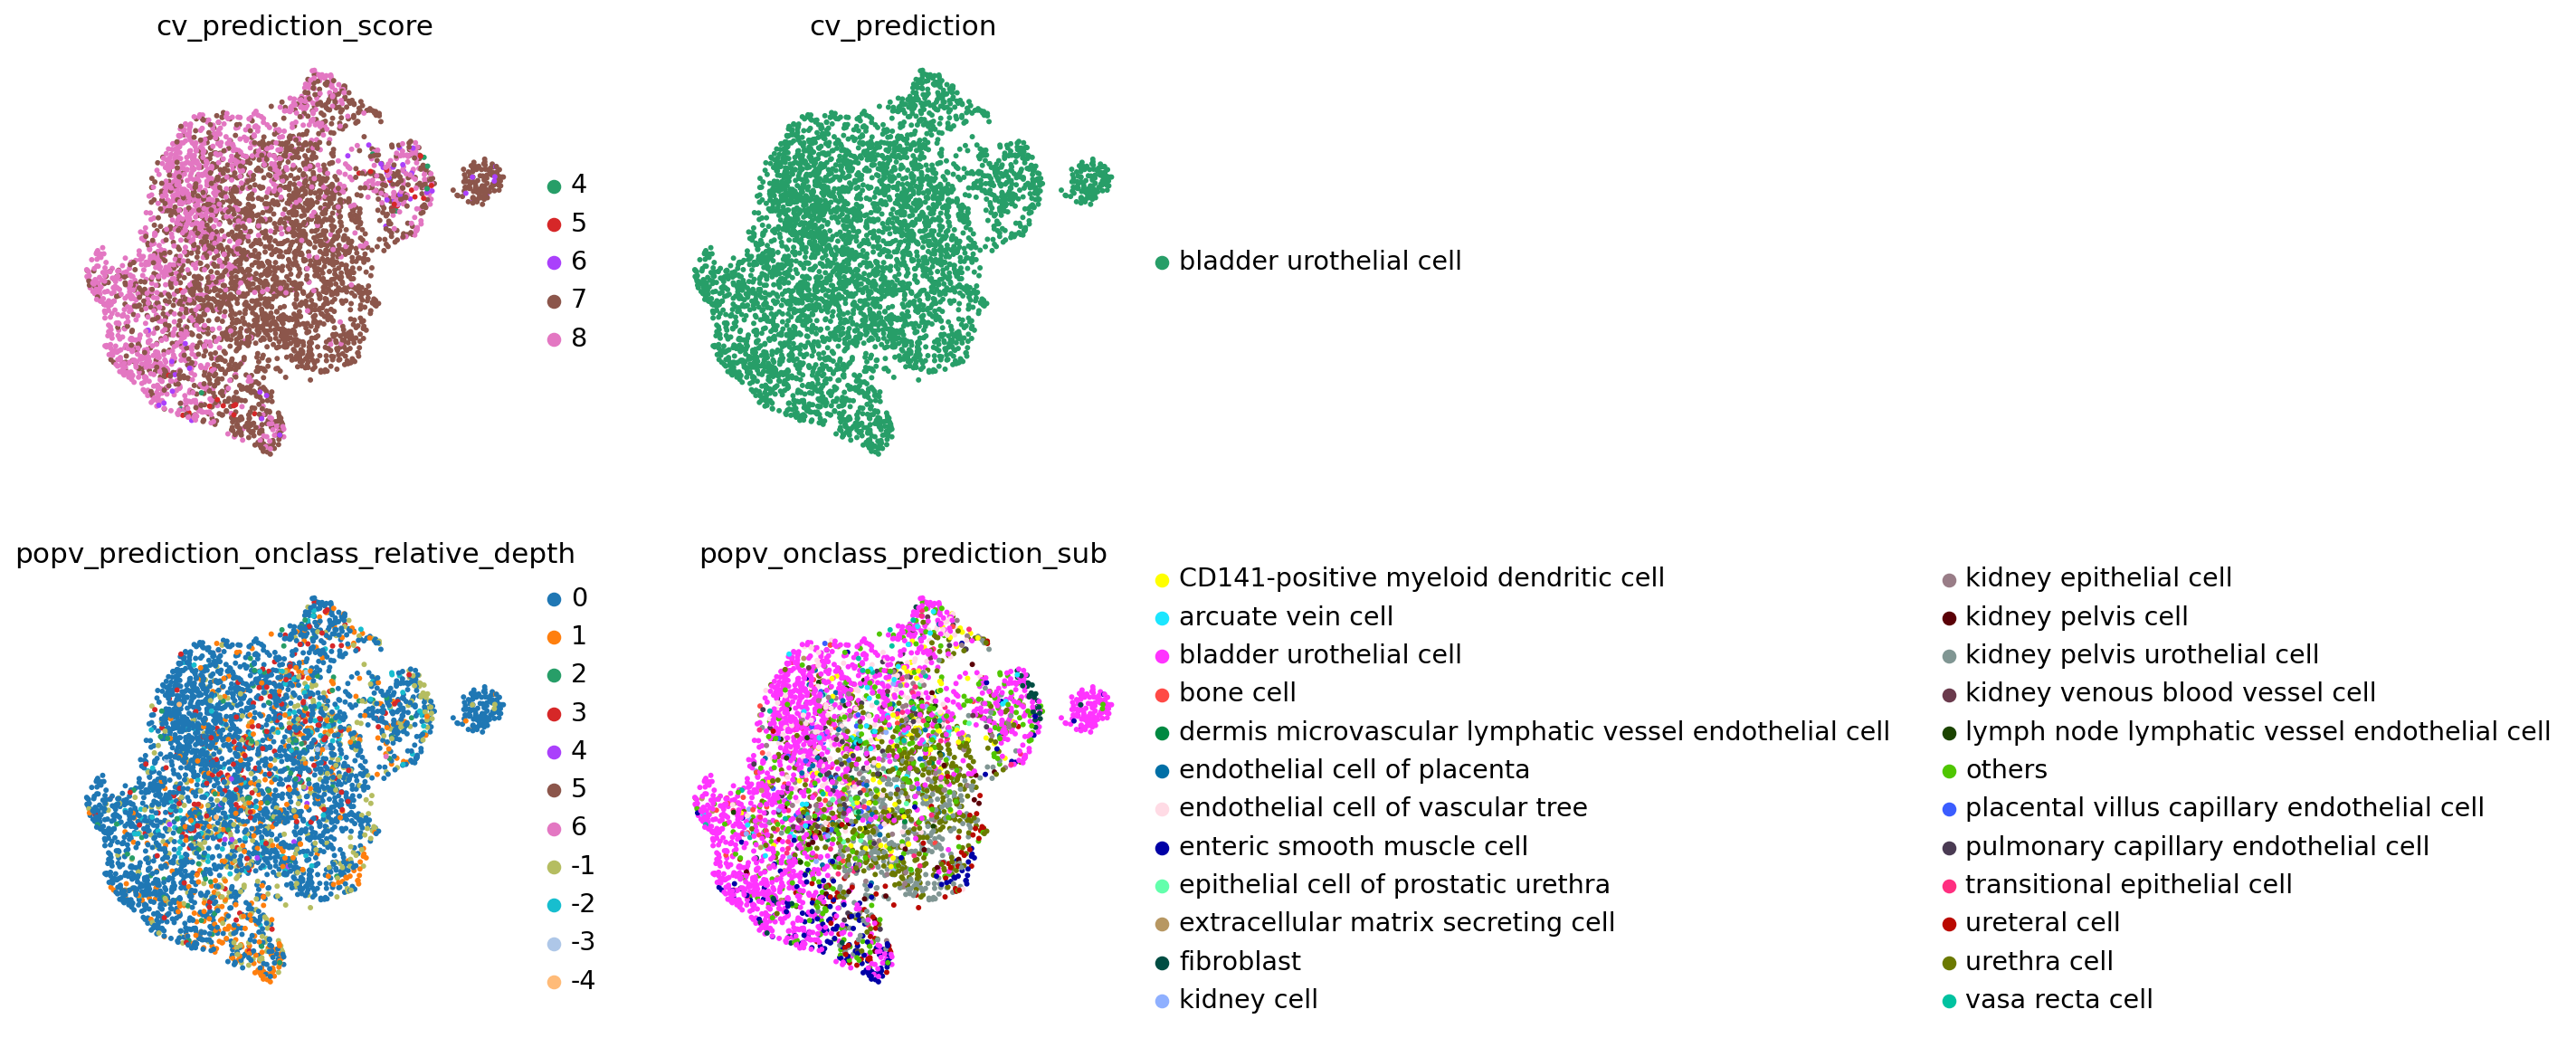

In [61]:
sc.pl.umap(
    urothelial,
    color=['cv_prediction_score', 'cv_prediction', 'popv_prediction_onclass_relative_depth', 'popv_onclass_prediction_sub'],
    ncols=2, save='onclass_epithelial_cells.pdf', frameon=False)

Making confusion matrix for popv_celltypist_prediction


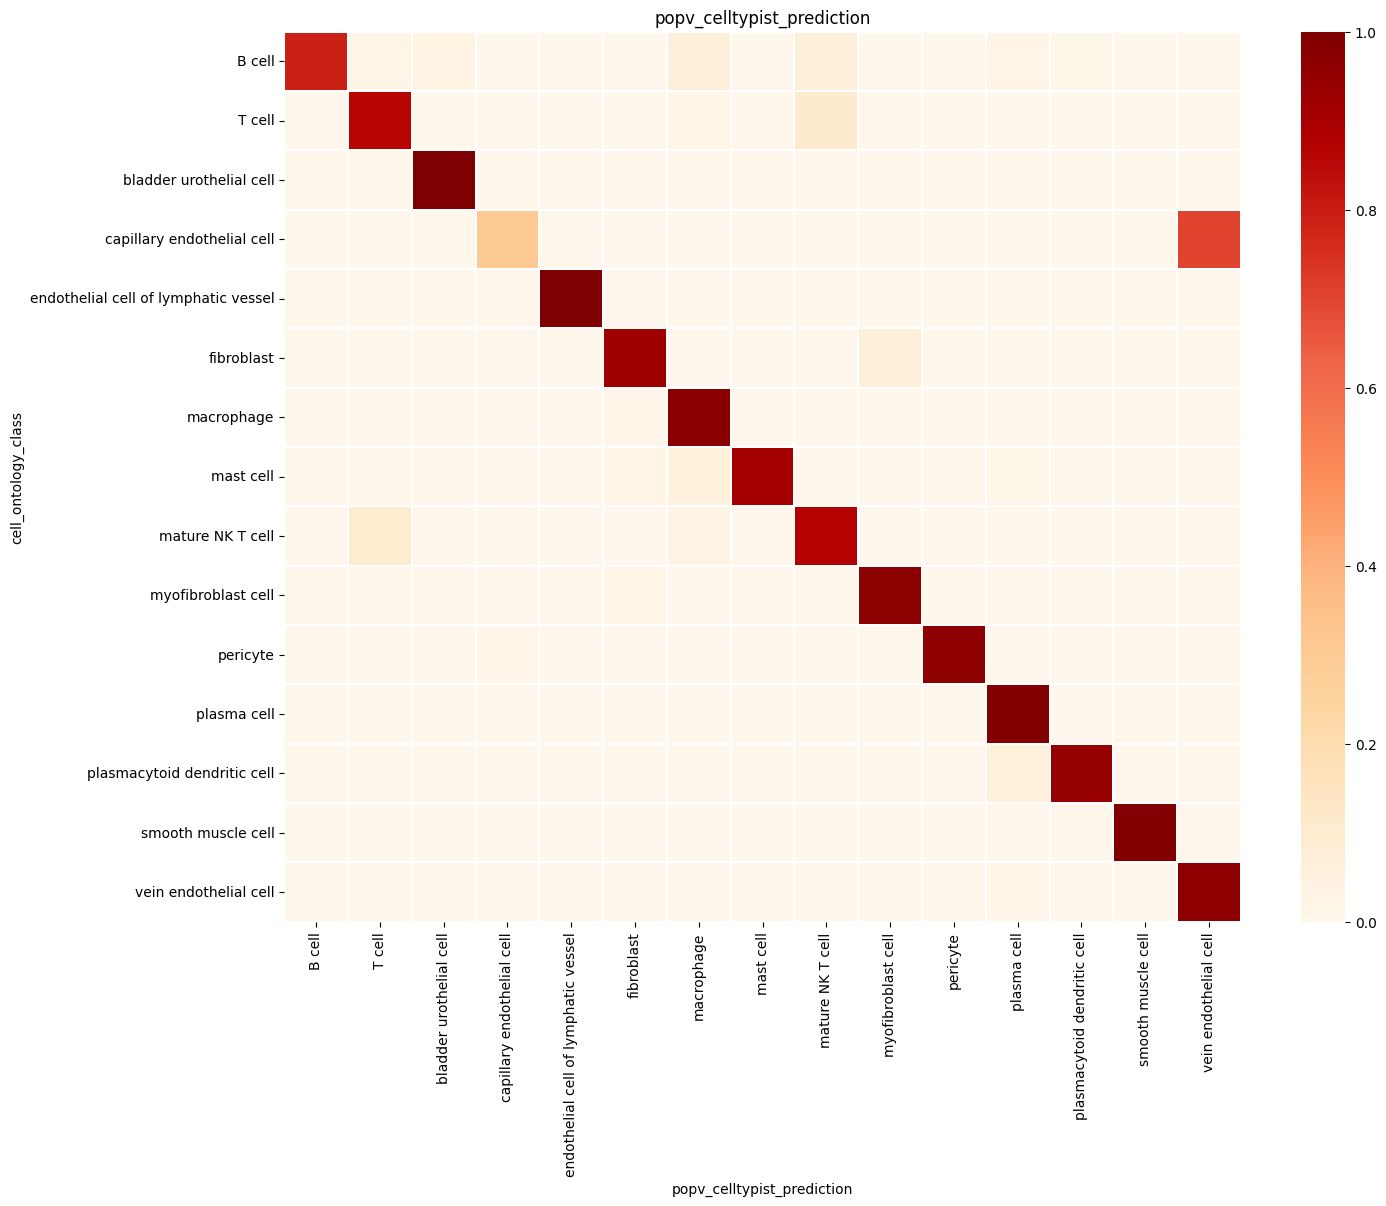

Making confusion matrix for popv_knn_on_bbknn_prediction


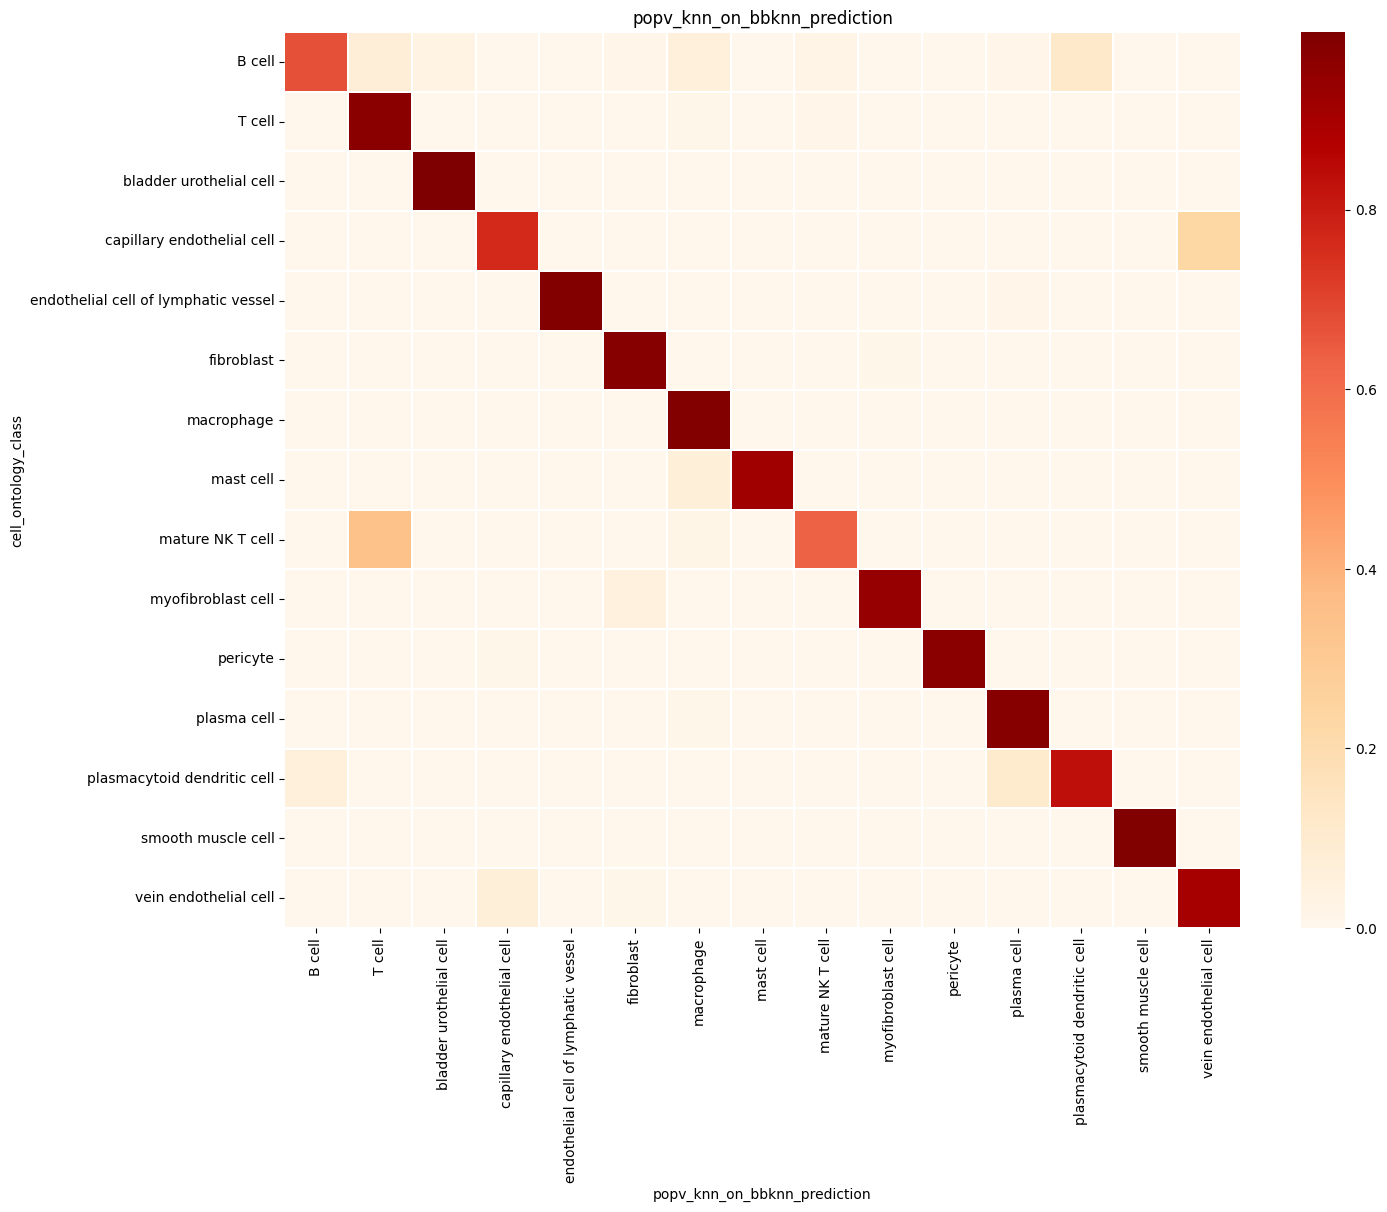

Making confusion matrix for popv_knn_on_scanorama_prediction


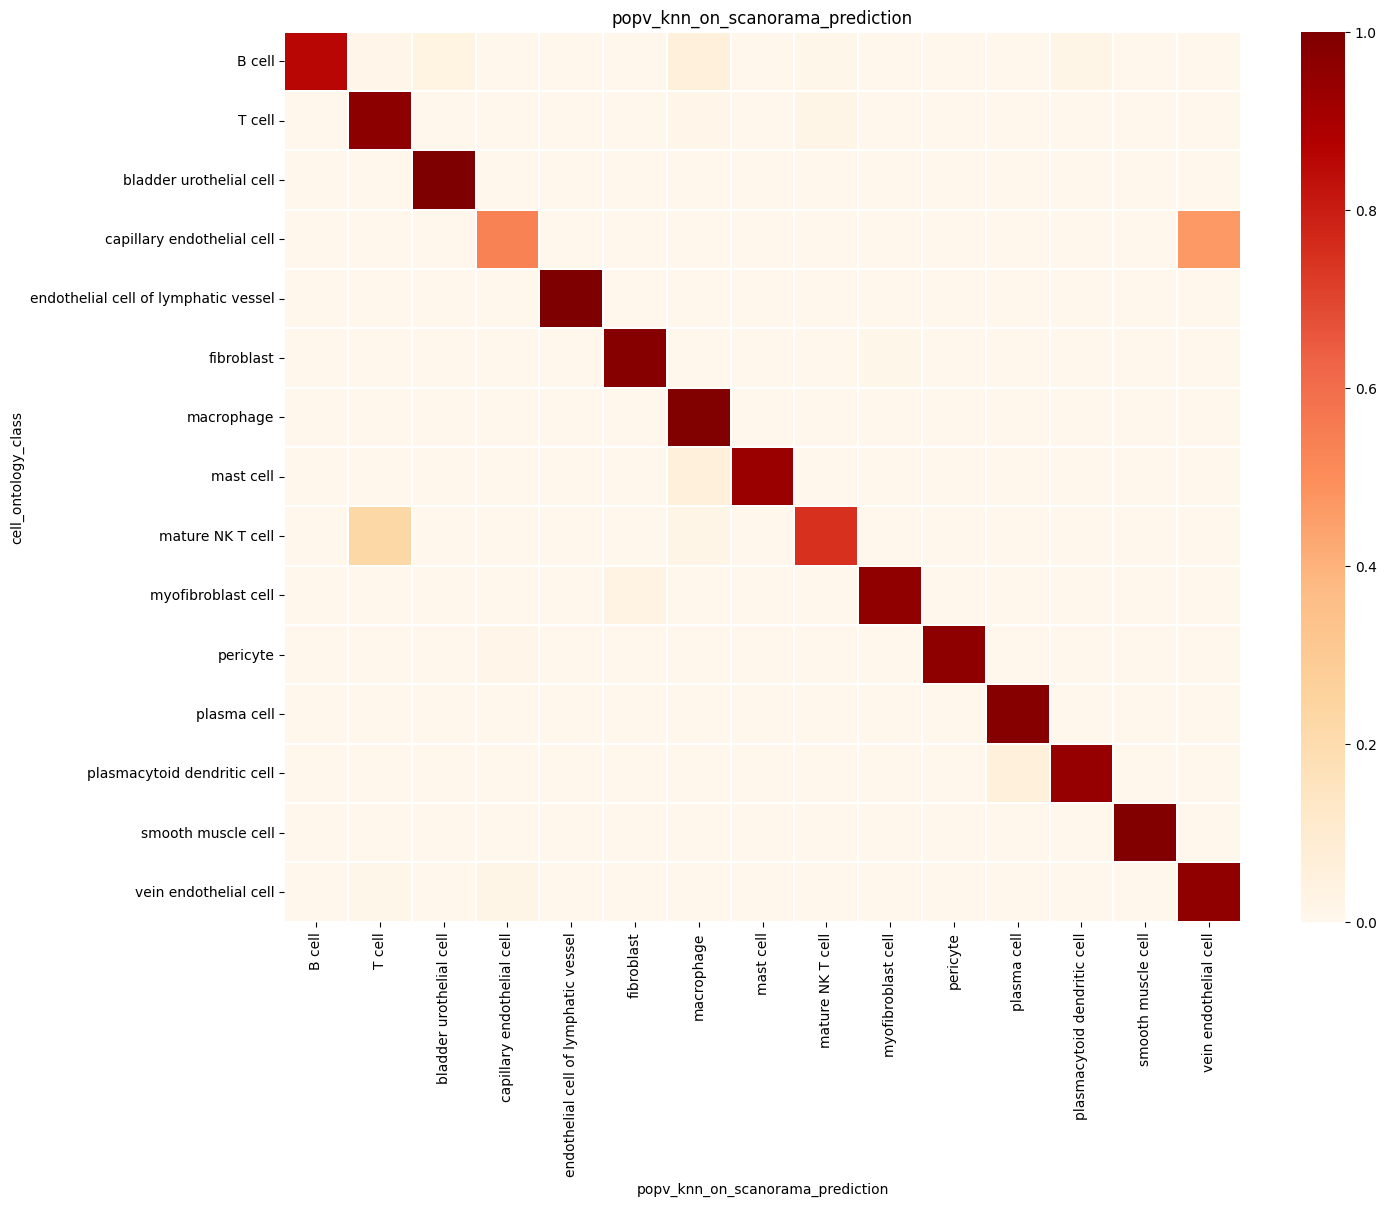

Making confusion matrix for popv_knn_on_scvi_prediction


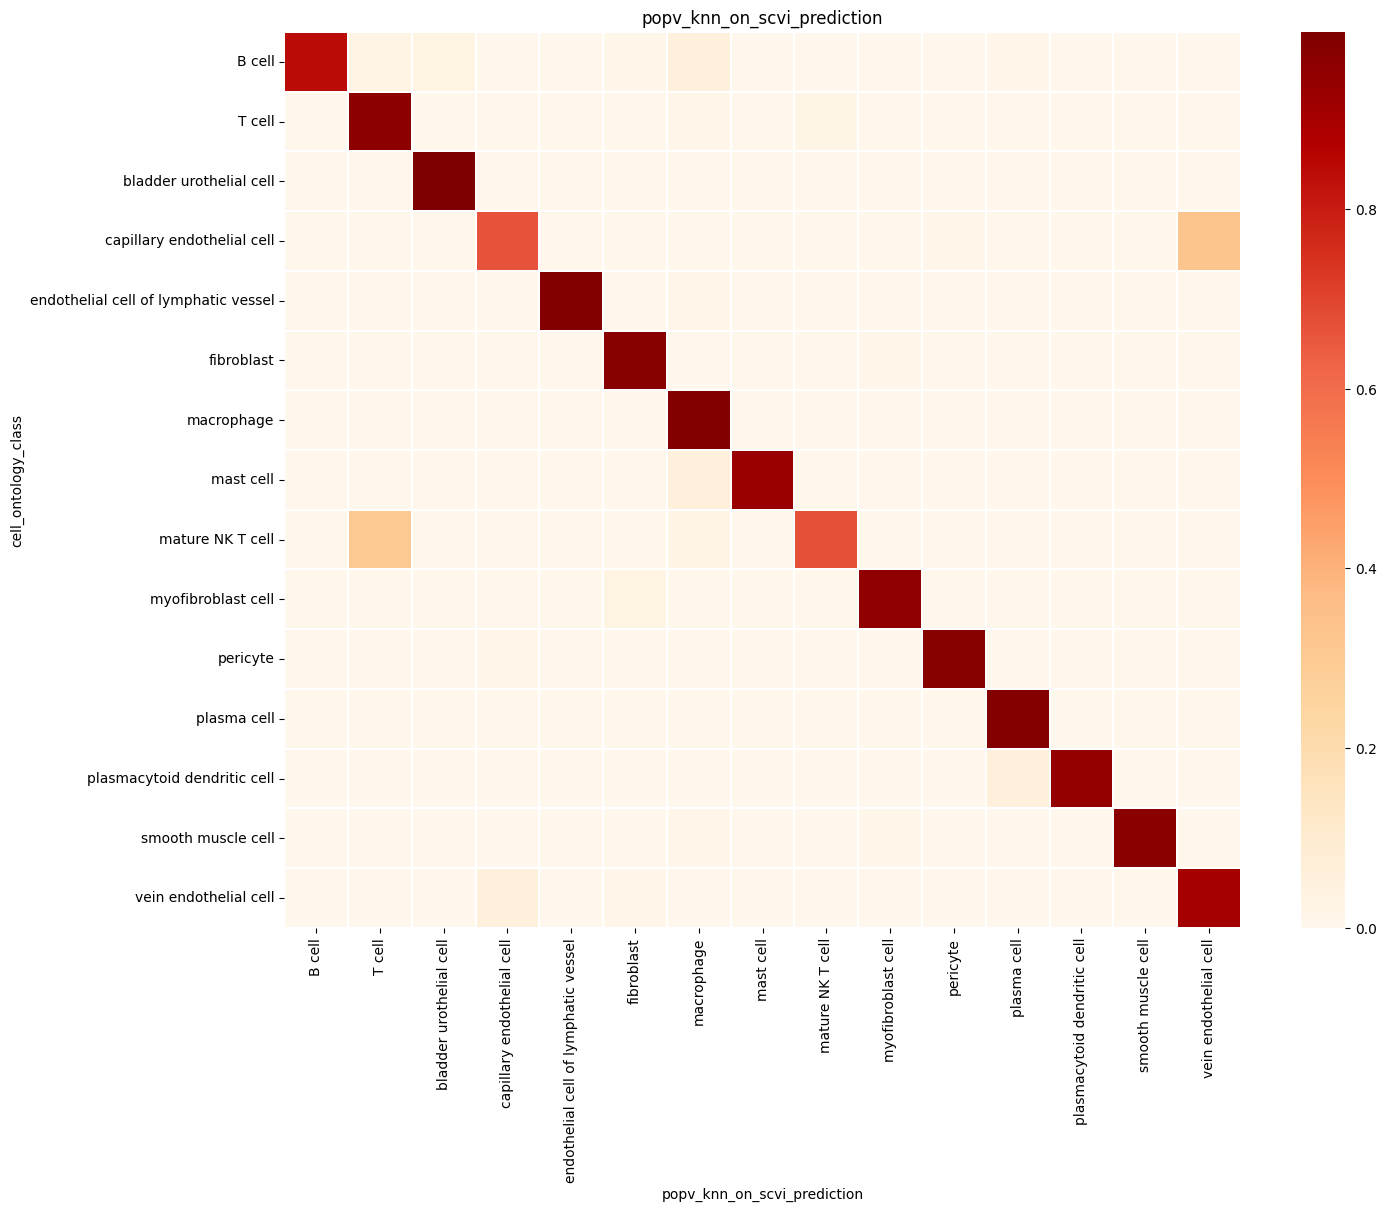

Making confusion matrix for popv_onclass_prediction


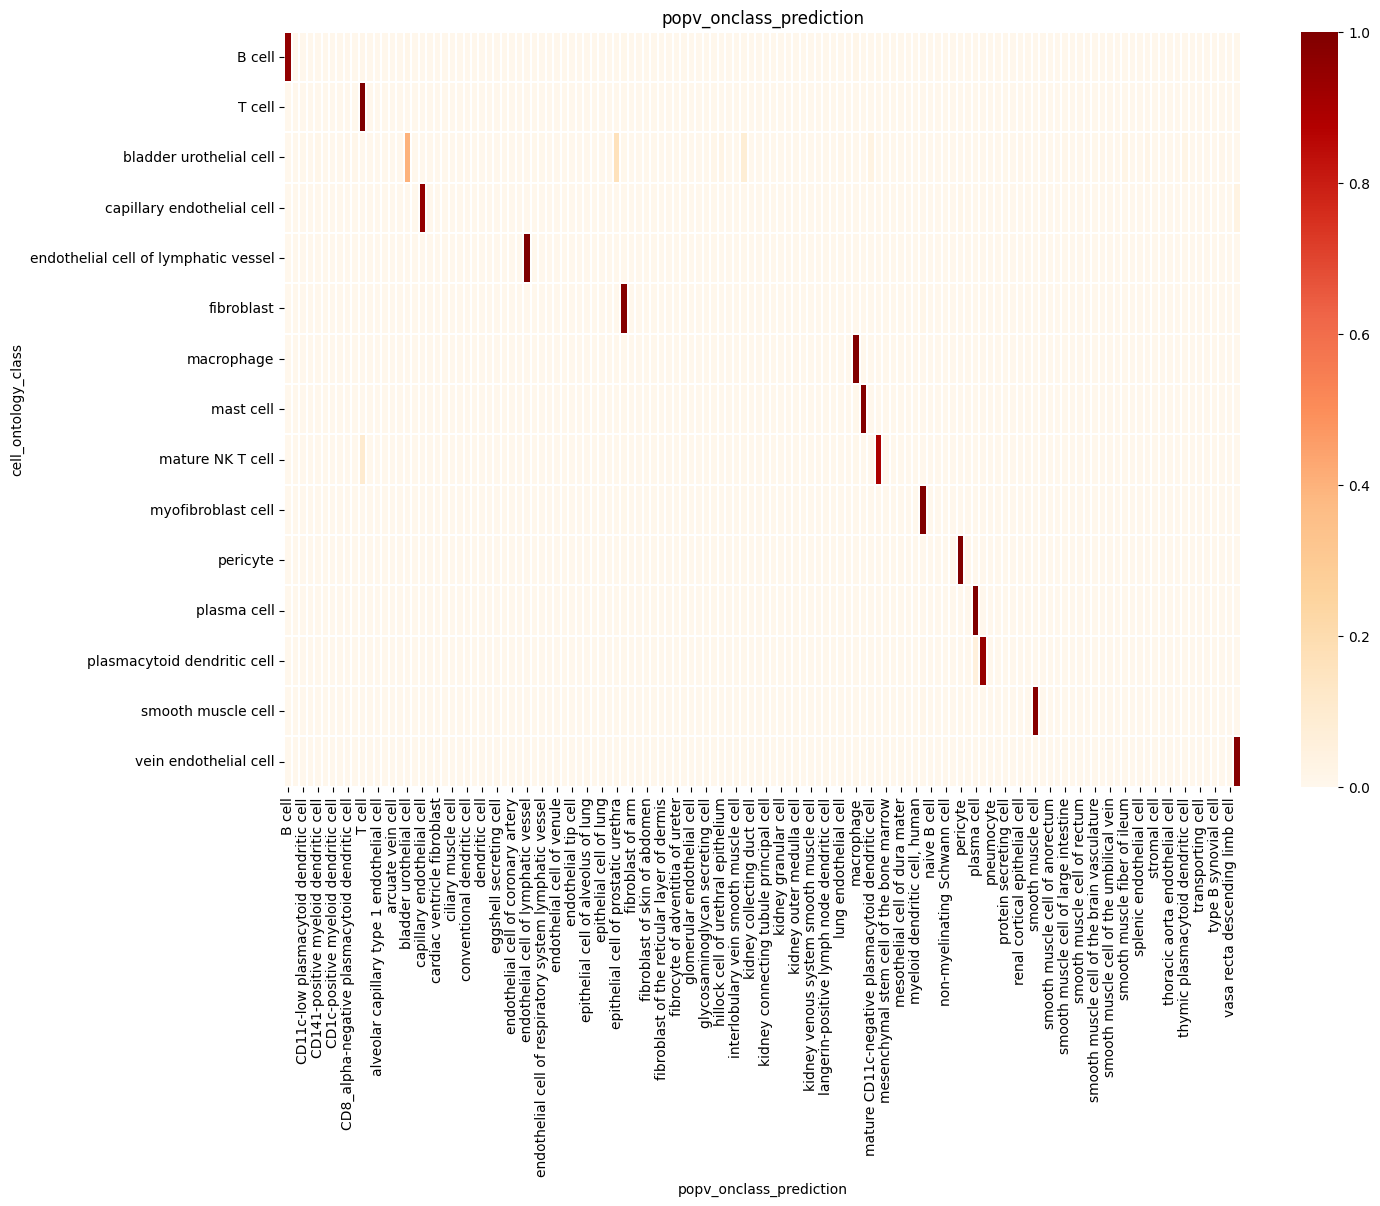

Making confusion matrix for popv_rf_prediction


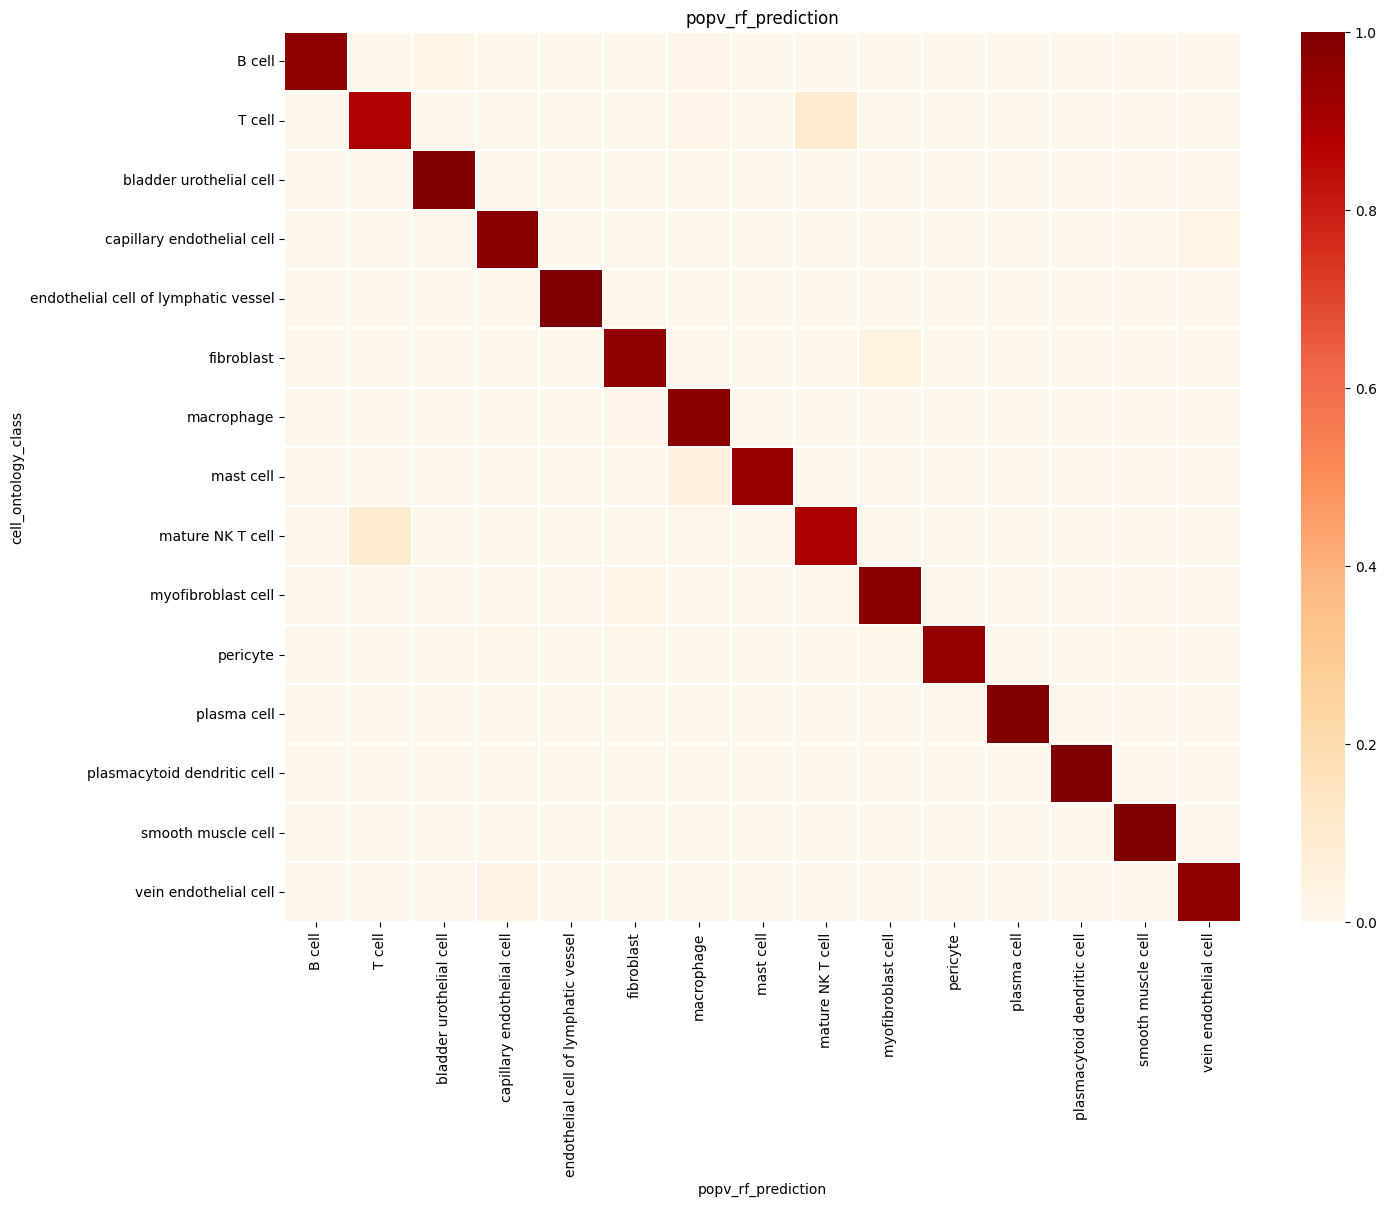

Making confusion matrix for popv_scanvi_prediction


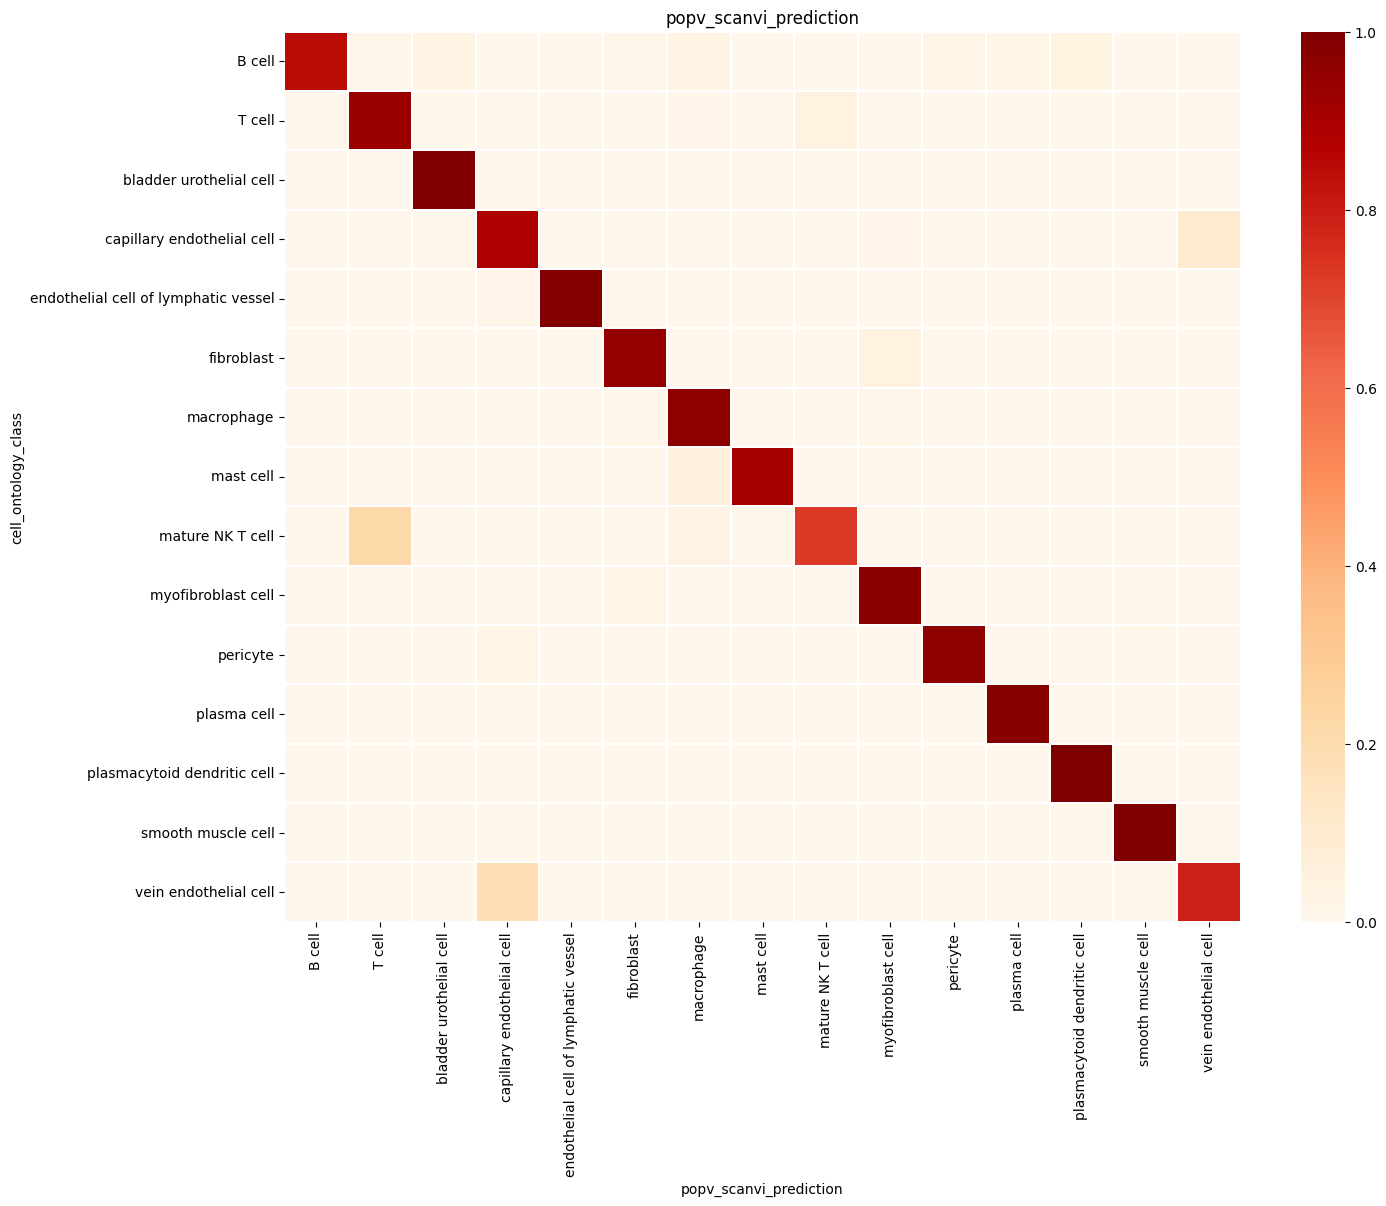

Making confusion matrix for popv_svm_prediction


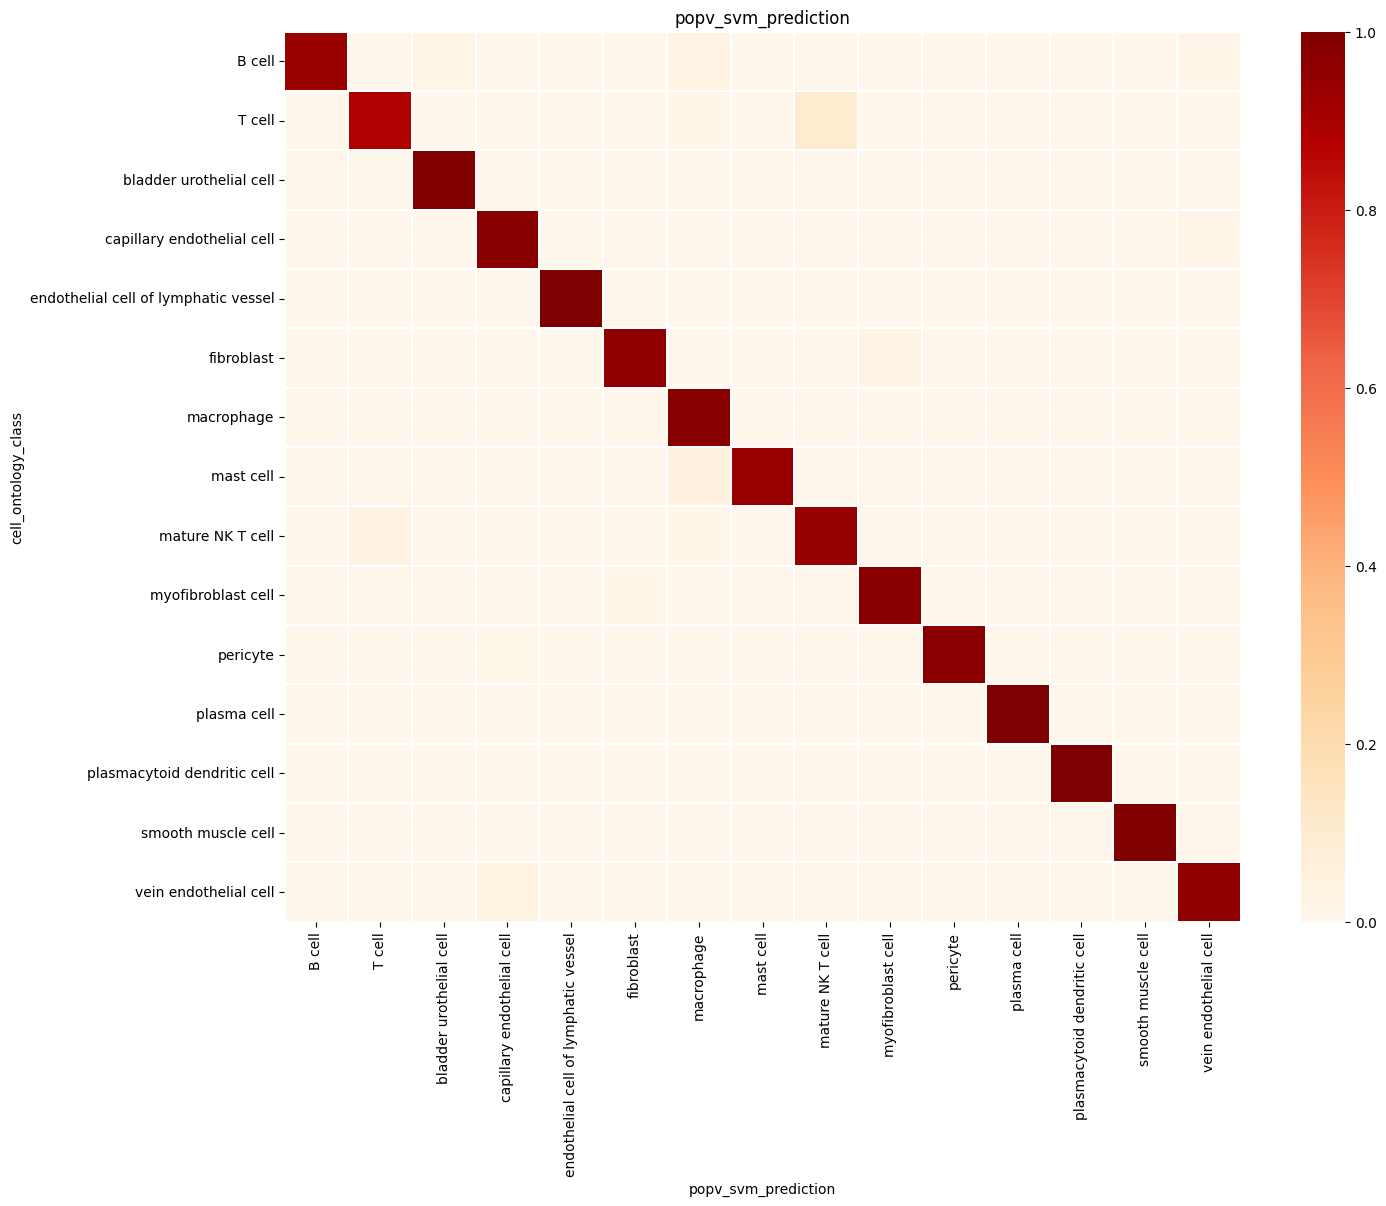

In [ ]:
popv.visualization.make_agreement_plots(
    query, prediction_keys=query.uns['prediction_keys'], popv_prediction_key='cell_ontology_class', save_folder='.')

In [ ]:
popv.visualization.make_agreement_plots(bladder, prediction_keys=['cv_prediction'], popv_prediction_key='cell_ontology_class', save_folder='.')

Making confusion matrix for cv_prediction


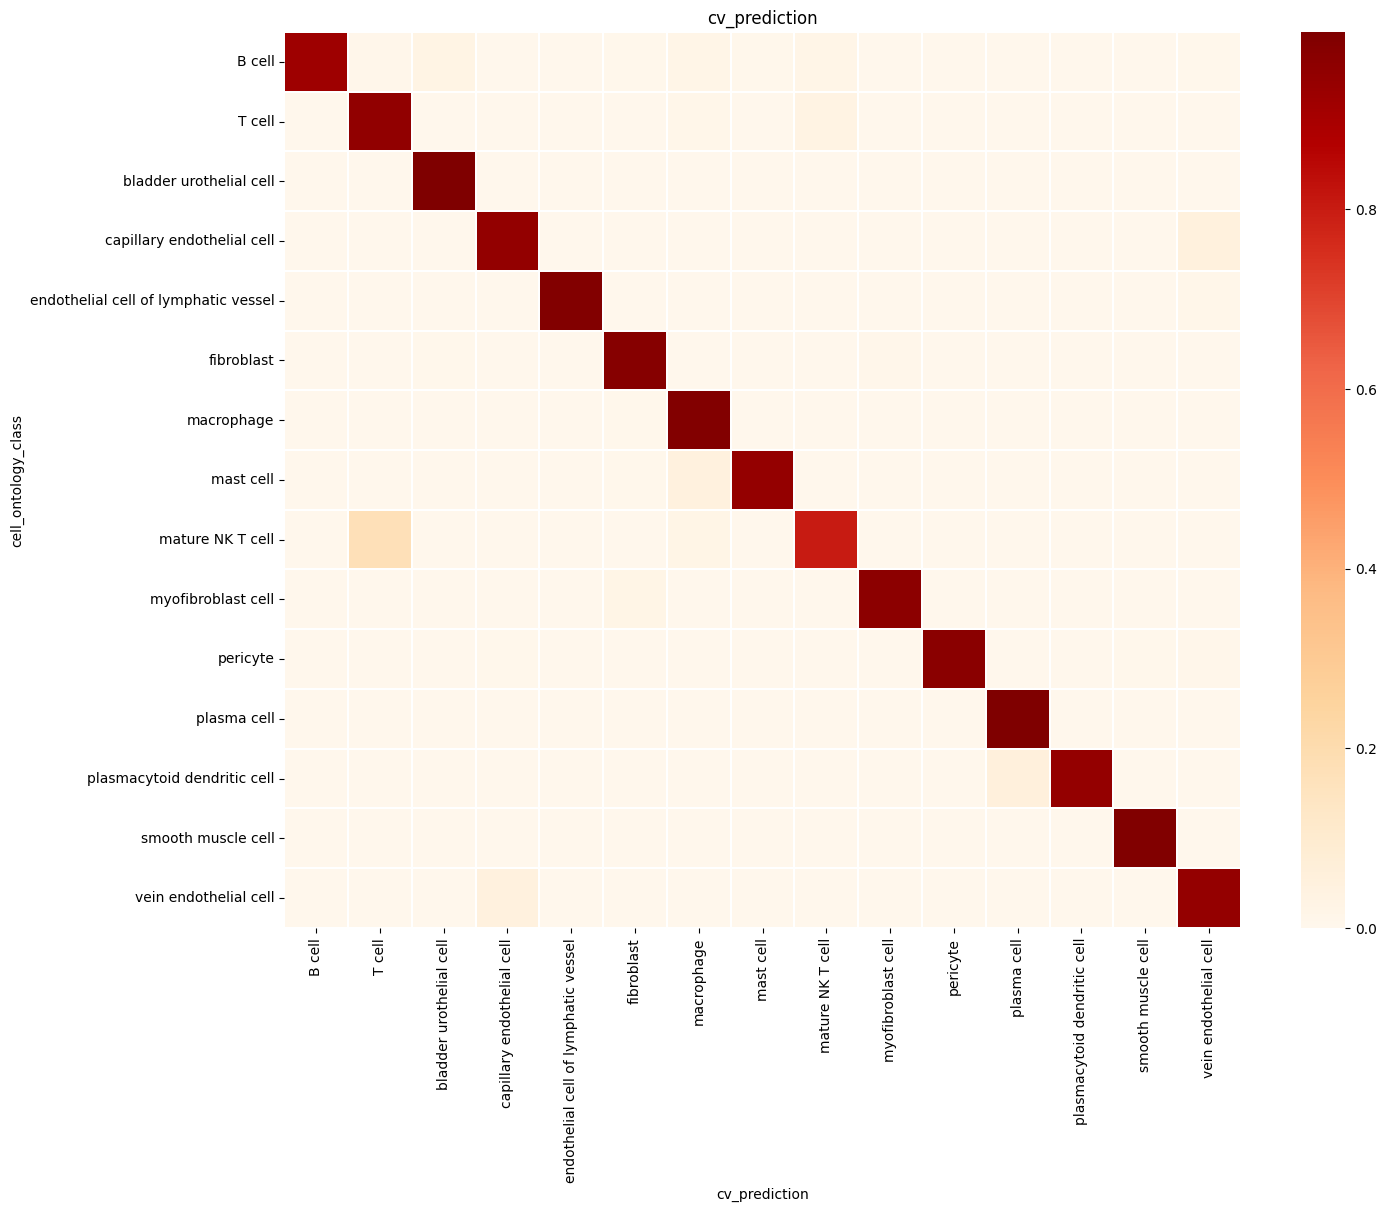

In [31]:
popv.visualization.make_agreement_plots(bladder, prediction_keys=['cv_prediction'], popv_prediction_key='cell_ontology_class', save_folder='.')

In [36]:
bladder.write('data/Bladder_cv_results_.h5ad')

## Weight matrix

In [2]:
from popv.reproducibility import _accuracy
import pandas as pd

In [3]:
bladder = sc.read('data/Bladder_cv_results_.h5ad')

In [4]:
i = 0
query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
pred_keys = query.uns['prediction_keys']

In [5]:
for key in pred_keys:
    _accuracy._absolute_accuracy(bladder, key, 'cell_ontology_class', save_key=key + '_abs_accuracy' )

In [6]:
bladder

AnnData object with n_obs × n_vars = 24583 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', 'cv_prediction', 'popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction', 'popv_prediction_depth', 'popv_prediction_onclass_relative_depth', 'cv_idx', 'popv_celltypist_prediction_abs_accuracy', 'popv_knn_on_bbknn_prediction_abs_accuracy', 'popv_knn_on_scanorama_prediction_abs_accuracy', 'popv_knn_on_scvi_prediction_abs_accuracy', 'popv_onclass_prediction_abs_accuracy', 'popv_rf_prediction_abs_accuracy', 'popv_scanvi_prediction_abs_accuracy', 'popv_svm_prediction_abs_accuracy'
    var: 'feature_type', 'ensemblid', 'highly_va

In [7]:
pred_acc_keys = [k + "_abs_accuracy" for k in pred_keys]

In [8]:
weight_matrix = pd.DataFrame(index=np.unique(bladder.obs[pred_keys]))

In [9]:
for pred_key, acc_key in zip(pred_keys, pred_acc_keys):
    weight_matrix[pred_key] = bladder.obs.groupby(pred_key).mean()[acc_key]

In [10]:
weight_matrix.head()

popv_celltypist_prediction  \
B cell                                                     0.768116   
B cell of anorectum                                             NaN   
B cell of appendix                                              NaN   
B cell of medullary sinus of lymph node                         NaN   
B cell, CD19-positive                                           NaN   

                                         popv_knn_on_bbknn_prediction  \
B cell                                                       0.924855   
B cell of anorectum                                               NaN   
B cell of appendix                                                NaN   
B cell of medullary sinus of lymph node                           NaN   
B cell, CD19-positive                                             NaN   

                                         popv_knn_on_scanorama_prediction  \
B cell                                                           0.977064   
B cell of anorectum                                                   NaN   
B cell of appendix                                                    NaN   
B cell of medullary sinus of lymph node                               NaN   
B cell, CD19-positive                                                 NaN   

                                         popv_knn_on_scvi_prediction  \
B cell                                                      0.981132   
B cell of anorectum                                              NaN   
B cell of appendix                                               NaN   
B cell of medullary sinus of lymph node                          NaN   
B cell, CD19-positive                                            NaN   

                                         popv_onclass_prediction  \
B cell                                                  0.995833   
B cell of anorectum                                     0.000000   
B cell of appendix                                      0.000000   
B cell of medullary sinus of lymph node                 0.000000   
B cell, CD19-positive                                   0.000000   

                                         popv_rf_prediction  \
B cell                                             0.672131   
B cell of anorectum                                     NaN   
B cell of appendix                                      NaN   
B cell of medullary sinus of lymph node                 NaN   
B cell, CD19-positive                                   NaN   

                                         popv_scanvi_prediction  \
B cell                                                 0.937778   
B cell of anorectum                                         NaN   
B cell of appendix                                          NaN   
B cell of medullary sinus of lymph node                     NaN   
B cell, CD19-positive                                       NaN   

                                         popv_svm_prediction  
B cell                                              0.790164  
B cell of anorectum                                      NaN  
B cell of appendix                                       NaN  
B cell of medullary sinus of lymph node                  NaN  
B cell, CD19-positive                                    NaN

In [11]:
weight_matrix = weight_matrix.replace(np.nan, 0)
weight_matrix = weight_matrix.replace(0, 1/len(np.unique(bladder.obs[pred_keys])))

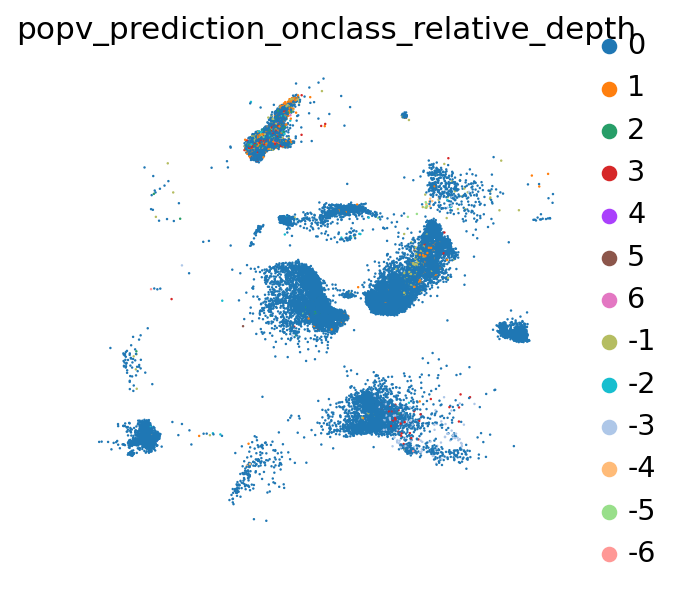

In [12]:
sc.pl.umap(bladder, color='popv_prediction_onclass_relative_depth')

In [13]:
bladder

AnnData object with n_obs × n_vars = 24583 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', 'cv_prediction', 'popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction', 'popv_prediction_depth', 'popv_prediction_onclass_relative_depth', 'cv_idx', 'popv_celltypist_prediction_abs_accuracy', 'popv_knn_on_bbknn_prediction_abs_accuracy', 'popv_knn_on_scanorama_prediction_abs_accuracy', 'popv_knn_on_scvi_prediction_abs_accuracy', 'popv_onclass_prediction_abs_accuracy', 'popv_rf_prediction_abs_accuracy', 'popv_scanvi_prediction_abs_accuracy', 'popv_svm_prediction_abs_accuracy'
    var: 'feature_type', 'ensemblid', 'highly_va

In [14]:
weight_matrix.to_csv('lung_weights.csv')

In [15]:
sc.pl.umap(lung, color=['assay_correct', 'compartment', 'cell_ontology_class', 'cv_prediction'], ncols=1, frameon=False)

NameError: name 'lung' is not defined